- 深度学习中常用的正则化包括：weight decay,batch normalization,dropout
- 正则化的目的是为了防止过拟合，提高模型的泛化能力
- 正则化的本质是在损失函数中加入正则项，正则项一般是模型参数的范数

In [87]:
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss().to(device)

# 加载数据
batch_size = 100
train_set = dsets.MNIST(root='../data/mnist/',train=True,transform=transforms.ToTensor())
test_set = dsets.MNIST(root='../data/mnist/',train=False,transform=transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True,num_workers=6)
test_dl = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,num_workers=6)

# 定义训练的辅助函数
def eval(model,criterion,dataloader):
    model.eval()
    loss, accurarcy = 0,0
    for batch_x,batch_y in dataloader:
        batch_x = batch_x.view(-1,784).to(device)
        batch_y = batch_y.to(device)
        
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()
        
        probs,pred_y = logits.data.max(dim=1)
        accurarcy += (pred_y==batch_y.data).sum().float()/batch_y.size(0)
        
    loss /= len(dataloader)
    accurarcy = accurarcy*100.0/len(dataloader)
    return loss,accurarcy
        
def train_epoch(net,criterion,optimizer,dataloader):
    for batch_x,batch_y in dataloader:
        batch_x = batch_x.view(-1,784).to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

In [88]:
# 取1000个训练样本构成新的训练集
train_set.data = train_set.data[0:1000]
train_set.targets = train_set.targets[0:1000]

In [89]:
net = nn.Linear(100,2).to(device)
optimizer = torch.optim.SGD(net.parameters(),
                            lr=0.1,
                            weight_decay=1e-4)

In [90]:
net1 = nn.Sequential(nn.Linear(784,500),
                     nn.ReLU(),
                     nn.Linear(500,500),
                     nn.ReLU(),
                     nn.Linear(500,10)).to(device)

In [91]:
net2 = nn.Sequential(nn.Linear(784,500),
                     nn.BatchNorm1d(500),
                     nn.ReLU(),
                     nn.Linear(500,500),
                     nn.BatchNorm1d(500),
                     nn.ReLU(),
                     nn.Linear(500,500),
                     nn.BatchNorm1d(500),
                     nn.ReLU(),
                     nn.Linear(500,10)).to(device)

In [92]:
optimizer1 = torch.optim.SGD(net1.parameters(),lr=0.1,momentum=0.9)
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1,momentum=0.9)
learn_hist1 = []
learn_hist2 = []
nepoches = 15

# 训练网络
print('Start training...')
for epoch in range(nepoches):
    train_epoch(net1,criterion,optimizer1,train_dl)
    tr_loss,tr_acc = eval(net1,criterion,train_dl)
    te_loss,te_acc = eval(net1,criterion,test_dl)
    learn_hist1.append((tr_loss,tr_acc,te_loss,te_acc))
    
    print('[%2d/%d], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(epoch+1,nepoches,tr_loss,tr_acc,te_loss,te_acc))
    
print('\n开始训练使用BN的网络...')
for epoch in range(nepoches):
    train_epoch(net2,criterion,optimizer2,train_dl)
    tr_loss,tr_acc = eval(net2,criterion,train_dl)
    te_loss,te_acc = eval(net2,criterion,test_dl)
    learn_hist2.append((tr_loss,tr_acc,te_loss,te_acc))
    
    print('[%2d/%d], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(epoch+1,nepoches,tr_loss,tr_acc,te_loss,te_acc))



Start training...
[ 1/15], train error: 2.0e+00, train acc: 63.10	 test error: 2.0e+00, test acc: 57.49
[ 2/15], train error: 7.5e-01, train acc: 77.50	 test error: 8.5e-01, test acc: 72.44
[ 3/15], train error: 5.0e-01, train acc: 85.20	 test error: 7.1e-01, test acc: 78.98
[ 4/15], train error: 3.2e-01, train acc: 89.90	 test error: 6.0e-01, test acc: 81.58
[ 5/15], train error: 2.1e-01, train acc: 93.70	 test error: 4.8e-01, test acc: 85.58
[ 6/15], train error: 2.0e-01, train acc: 93.50	 test error: 5.8e-01, test acc: 83.49
[ 7/15], train error: 9.3e-02, train acc: 97.50	 test error: 4.9e-01, test acc: 86.48
[ 8/15], train error: 5.9e-02, train acc: 98.70	 test error: 4.9e-01, test acc: 86.55
[ 9/15], train error: 4.5e-02, train acc: 99.00	 test error: 4.9e-01, test acc: 87.57
[10/15], train error: 2.4e-02, train acc: 99.80	 test error: 5.5e-01, test acc: 86.83
[11/15], train error: 1.6e-02, train acc: 100.00	 test error: 5.9e-01, test acc: 85.91
[12/15], train error: 9.8e-03, trai

In [97]:
[t[3] for t in learn_hist1]

[tensor(57.4900, device='mps:0'),
 tensor(72.4400, device='mps:0'),
 tensor(78.9800, device='mps:0'),
 tensor(81.5800, device='mps:0'),
 tensor(85.5800, device='mps:0'),
 tensor(83.4900, device='mps:0'),
 tensor(86.4800, device='mps:0'),
 tensor(86.5500, device='mps:0'),
 tensor(87.5700, device='mps:0'),
 tensor(86.8300, device='mps:0'),
 tensor(85.9100, device='mps:0'),
 tensor(86.9500, device='mps:0'),
 tensor(87.6300, device='mps:0'),
 tensor(87.7800, device='mps:0'),
 tensor(87.5700, device='mps:0')]

Text(0, 0.5, 'accuracy')

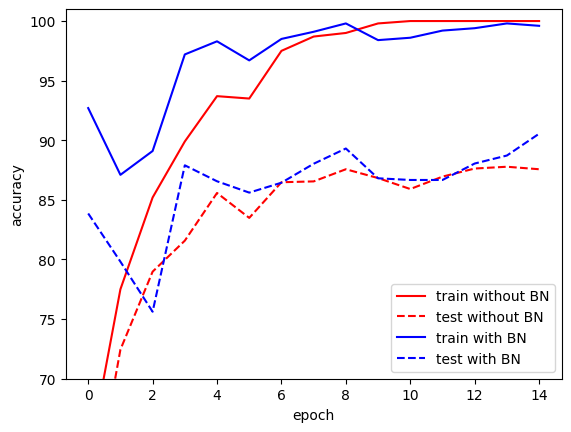

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[1].to('cpu') for t in learn_hist1],'r-',label='train without BN')
plt.plot([t[3].to('cpu') for t in learn_hist1],'r--',label='test without BN')

plt.plot([t[1].to('cpu') for t in learn_hist2],'b-',label='train with BN')
plt.plot([t[3].to('cpu') for t in learn_hist2],'b--',label='test with BN')

plt.ylim(70,101)
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')    

使用Dropout防止过拟合

In [100]:
Width = 5000
p =0.7
net3 = nn.Sequential(nn.Linear(784,Width),
                     nn.Dropout(p),
                     nn.ReLU(),
                     nn.Linear(Width,Width),
                     nn.Dropout(p),
                     nn.ReLU(),
                     nn.Linear(Width,10)).to(device)


In [101]:
net3.eval()
print(net3.training)

False


In [102]:
net3.train()
print(net3.training)

True


In [103]:
optimizer3 = torch.optim.SGD(net3.parameters(),lr=0.1,momentum=0.9)
learn_hist3 = []
nepoches = 20

#训练网络
print('Start training...')
for epoch in range(nepoches):
    train_epoch(net3,criterion,optimizer3,train_dl)
    tr_loss,tr_acc = eval(net3,criterion,train_dl)
    te_loss,te_acc = eval(net3,criterion,test_dl)
    learn_hist3.append((tr_loss,tr_acc,te_loss,te_acc))
    
    print('[%2d/%d], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(epoch+1,nepoches,tr_loss,tr_acc,te_loss,te_acc))
net3.zero_grad()



Start training...
[ 1/20], train error: 1.2e+00, train acc: 78.90	 test error: 1.3e+00, test acc: 73.19
[ 2/20], train error: 4.8e-01, train acc: 85.00	 test error: 7.9e-01, test acc: 77.31
[ 3/20], train error: 4.0e-01, train acc: 88.50	 test error: 7.9e-01, test acc: 79.38
[ 4/20], train error: 2.1e-01, train acc: 93.30	 test error: 5.4e-01, test acc: 83.74
[ 5/20], train error: 7.6e-02, train acc: 98.50	 test error: 4.0e-01, test acc: 88.13
[ 6/20], train error: 4.7e-02, train acc: 99.10	 test error: 4.8e-01, test acc: 86.58
[ 7/20], train error: 1.4e-02, train acc: 99.90	 test error: 4.3e-01, test acc: 88.78
[ 8/20], train error: 6.6e-03, train acc: 100.00	 test error: 4.3e-01, test acc: 89.40
[ 9/20], train error: 4.2e-03, train acc: 100.00	 test error: 4.3e-01, test acc: 89.73
[10/20], train error: 2.8e-03, train acc: 100.00	 test error: 4.4e-01, test acc: 89.53
[11/20], train error: 2.2e-03, train acc: 100.00	 test error: 4.5e-01, test acc: 89.55
[12/20], train error: 1.9e-03, t

没有Dropout的情况

In [104]:
net4 = nn.Sequential(nn.Linear(784,Width), 
                     nn.ReLU(),
                     nn.Linear(Width,Width),
                     nn.ReLU(),
                     nn.Linear(Width,10)).to(device)
optimizer4 = torch.optim.SGD(net4.parameters(),lr=0.1,momentum=0.9)
learn_hist4 = []
nepoches = 20

#训练网络
print('Start training...')
for epoch in range(nepoches):
    train_epoch(net4,criterion,optimizer4,train_dl)
    tr_loss,tr_acc = eval(net4,criterion,train_dl)
    te_loss,te_acc = eval(net4,criterion,test_dl)
    learn_hist4.append((tr_loss,tr_acc,te_loss,te_acc))
    
    print('[%2d/%d], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(epoch+1,nepoches,tr_loss,tr_acc,te_loss,te_acc))
net3.zero_grad()



Start training...
[ 1/20], train error: 1.1e+00, train acc: 75.80	 test error: 1.2e+00, test acc: 72.27
[ 2/20], train error: 4.5e-01, train acc: 85.70	 test error: 6.9e-01, test acc: 78.54
[ 3/20], train error: 3.3e-01, train acc: 88.90	 test error: 6.5e-01, test acc: 80.60
[ 4/20], train error: 2.3e-01, train acc: 93.00	 test error: 5.0e-01, test acc: 84.55
[ 5/20], train error: 8.9e-02, train acc: 97.60	 test error: 4.3e-01, test acc: 87.21
[ 6/20], train error: 4.3e-02, train acc: 99.10	 test error: 4.3e-01, test acc: 88.09
[ 7/20], train error: 1.6e-02, train acc: 100.00	 test error: 4.3e-01, test acc: 88.51
[ 8/20], train error: 1.2e-02, train acc: 100.00	 test error: 4.6e-01, test acc: 88.58
[ 9/20], train error: 5.1e-03, train acc: 100.00	 test error: 4.4e-01, test acc: 89.01
[10/20], train error: 3.8e-03, train acc: 100.00	 test error: 4.6e-01, test acc: 89.06
[11/20], train error: 3.0e-03, train acc: 100.00	 test error: 4.7e-01, test acc: 89.09
[12/20], train error: 2.4e-03, 

Text(0, 0.5, 'accuracy')

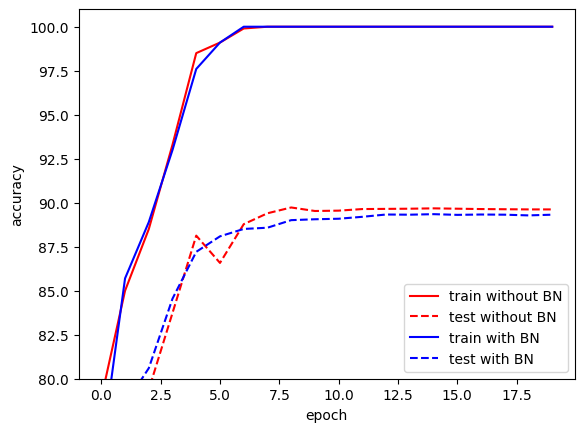

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[1].to('cpu') for t in learn_hist3],'r-',label='train without BN')
plt.plot([t[3].to('cpu') for t in learn_hist3],'r--',label='test without BN')

plt.plot([t[1].to('cpu') for t in learn_hist4],'b-',label='train with BN')
plt.plot([t[3].to('cpu') for t in learn_hist4],'b--',label='test with BN')

plt.ylim (80,101)
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')    